In [1]:
#@title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs182-minGPT_sp23'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182-minGPT'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [3]:
#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("cs182-minGPT"):
  !git clone https://github.com/avikam-chauhan/cs282_project_gpt_jax-homework
%cd cs182-minGPT
%cd cs282_project_gpt_jax-homework

/content/gdrive/My Drive/cs182-minGPT_sp23
fatal: destination path 'cs282_project_gpt_jax-homework' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'cs182-minGPT'
/content/gdrive/My Drive/cs182-minGPT_sp23
/content/gdrive/My Drive/cs182-minGPT_sp23/cs282_project_gpt_jax-homework


# Introduction to Coding in jax and flax
In this homework, we will be exploring the world of [Flax](http://flax.readthedocs.io/) and [Jax](https://github.com/google/jax), two powerful deep learning libraries made by Google that can be used to reimplement the PyTorch version of minGPT. Jax and Flax are both built on the concept of functional programming and provide a high-level interface for building and training neural networks, which can simplify the development process and reduce the amount of boilerplate code that needs to be written. Flax and Jax are designed to take advantage of modern hardware architectures such as GPUs and TPUs, which can significantly speed up the training process and reduce the time-to-deployment for new models.
<br/> By using these libraries, you will gain a deeper understanding of the underlying principles of neural networks and develop your skills in functional programming. You will also have the opportunity to compare and contrast the PyTorch and Flax/Jax versions of minGPT, gaining valuable insights into the similarities and differences between these powerful tools. So let's roll up our sleeves and dive into the world of Flax and Jax!


Before we start implementing the GPT architecture the libraries `jax` [(Jax Docs)](https://jax.readthedocs.io/en/latest/index.html) and `flax` [(Flax Docs)](https://flax.readthedocs.io/en/latest/) should be introduced as they have some key differences from pytorch functionalities. These differences are explained in detail [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers). 

#### Before you start coding, make sure you turn on GPU runtime. You can do this by going to Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU

## Jax introduction

First let us start with `jax`. In practice `jax` works almost exactly as `numpy` but use own datatypes which is more convenient in the context of high-performance numerical computing (HPC). Experience with such libraries is crucial as modern ML applications require resources that is beoynd the capabilities of a personal computer. Furthermore, `jax` supports automatic differentiation in both forward- and reverse-mode as well as accelerated linear algebra ([XLA](https://www.tensorflow.org/xla) - domain-specific compiler) .

### Random Number Generation

The first difference between `jax` and `numpy` we are going to highlight is ***how you generate random numbers***. In the code block below we demonstrate how you generate a random vector $x, x\in\mathbb{R}^{10}, x_i \sim \mathcal{N}(0,1)$. You can read more about the PRNG design [here](https://github.com/google/jax/blob/main/docs/jep/263-prng.md). A major advantage of this design is **reproducible program execution in a backend-independent way**. This is of major imortance for validating new discoveries within ML research as a many components (weight and bias initialization, dropout, masking, etc.) depend on PRNGs.

In [4]:
from jax import random
size = (10,)
key = random.PRNGKey(1)
# generate random vector with std normal distributed elements
x = random.normal(key, size)
x
# alternatively use a mu sigma^2 normal distributed vector
# x = mu + sigma2*random.normal(key,size)

Array([ 0.690805  , -0.48744103, -1.155789  ,  0.12108463, -0.19598432,
       -0.5078766 ,  0.91568655,  1.70968   , -0.36749417,  0.14315689],      dtype=float32)

To prevent generating random numbers from the same state represented by the variable `key`, the PRNG is split to get usable subkeys every time a new pseudorandom number is needed.

In [ ]:
# copied from hax common gotchas
print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

old key [0 1]
    \---SPLIT --> new key    [2441914641 1384938218]
             \--> new subkey [3819641963 2025898573] --> normal [-1.1470195]


### Pure functions

`jax` is a language of expressing and composing transformations of numerical programs and compile these programs for both CPU and accelerators (GPU/TPU). Compiling across devices requires that the code is written with certain constraints. One of the constraings is that the transformations and compilations are designed to only work on ***pure functions*** [pure functions link](https://en.wikipedia.org/wiki/Pure_function). This means that all the input data is passed through the function parameters, all the results are output throught hte functions results. Consequently, a pure function will always give the same output for the same input. In the below code block we have provided some examples of impure functions.

In [9]:
from jax import jit
import jax.numpy as jnp
# using global
global_var = 1
def impure_input_is_output(x):
    return x + global_var
# uses initial assignment of the global variable
print(jit(impure_input_is_output)(1))
global_var = 10.
# subsequent runs may cached value of the previous print
print(jit(impure_input_is_output)(2))
# when the type is changed the las update of the global variable is used
print(jit(impure_input_is_output)(jnp.array([1]) ) )

############
# Add more #
# examples #
############

2
3
[11.]


### In-place updates

Another important difference to `numpy` is how in-place update are done. `jax` offers a functional array update using the `.at` property. This difference is examplified in the code block below.

In [15]:
import numpy as np
import jax.numpy as jnp

#### Numpy #####
np_arr = np.zeros((3,3), dtype=np.float64)
print(np_arr)
# in place, mutating update
np_arr[1,:] = 1
print(np_arr)

#### Jax #####
# not that float 64 is not available, try by running the
# commented-out line below
#jnp_arr = jnp.zeros((3,3), dtype = jnp.float64)
jnp_arr = jnp.zeros((3,3), dtype = jnp.float32)
jnp_arr[1,:] = 1

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


TypeError: ignored

In [ ]:
#### correct jax in-place update ####
jnp_arr.at[1,:].add(1)

### Permissive inputs

`jax` requires premissive inputs. While `numpy` accepts lists or tuples as inputs, `jax` do not.

In [ ]:
print(np.sum([1,1,1]))
jnp.sum([1,1,1])

In [ ]:
# first convert to jnp array and then sum
print(jnp.sum(jnp.array([1,1,1])))

### Out-of-bounds indexing
For out-of-bound indexing `numpy` provides an error clearly explaining the error. In `jax` this is not so simple as raising an error from an accelerator (GPU/TPU) might be impossible or very difficult. Therefore, updates out-of-bounds will be skipped and the values will be filled with some value (in some cases the last value of the array but the behaviour is undefined) or some user-defined fill value using `.at[index].get(mode='fill', fill_value=fill_value')`. **Note** that when doing reverse mode automatic differentiation which turns index updates into index retrievals and vice versa will not preserve the semantics of out of bounds indexing. Therefore, out-of-bounds indexing should be thought of as undefined behaviour in `jax`.

In [ ]:
np.arange(10)[10]

In [ ]:
print("Simple indexing: ", jnp.arange(10)[10])
print("Using the ndarray at: ", jnp.arange(10).at[11].get())
print("Using the ndarray at and fill values out-of-bounds with nan's: ",jnp.arange(10.0).at[11].get(mode='fill', fill_value=jnp.nan))

## Flax introduction

### Model parameters and initialization
Parameters are not stored with the models themselves. You need to initialize parameters by calling the `init` function, using a PRNGKey and dummy input data. The parameter will have the shape of a nested dictionary whose leaves are `jax.numpy.array`'s.

In [5]:
import flax.linen as nn
import jax
model = nn.Dense(features = 4)
key1, key2 = random.split(random.PRNGKey(1), 2)
minval, maxval = 0,10
# generate a randomly initialized input
x = random.randint(key1, (4, 10), minval, maxval)
# initialiaze the parameters
params = model.init({'params' : key2}, x)
# Checking output shapes
jax.tree_util.tree_map(lambda x: x.shape, params) 
# apply the model on the input data
y = model.apply(params, x)
y

Array([[-5.444744 ,  1.8421361, -3.9907808,  7.4054146],
       [-3.2136657,  0.9437195,  0.7808636,  6.9177117],
       [ 0.7469003, -0.9826737,  6.9361224,  7.9343   ],
       [-0.3477633, -1.3661789,  1.723776 ,  6.7379627]], dtype=float32)

### Note the following about the above code block
- the RNG has to be passed in the `model.init` function as the first argument if you are not explicitly using keyword and then the the input data
- when applying the model on the input data additional RNGs as to be passed as a dictionary using the keyword `rngs = {'prng_name' : prng_key}` where the name is the same as you used when initializing the parameters
- all the RNGs that is going to be used in the model has to be initialized in the `model.init`-function

### Setting the parameters manually
1. flatten the parameter dictionary
2. edit the flattened parameters by setting new values to keys given by the flattened parameter dictionary
3. unflatten the parameters
4. freeze the parameters
5. now the paremeters can be applied to the same model with different values.

**Note** in the fully connected layers of the MLP the dimensions are flipped due to an implementation choice in `jax`, advice [here](https://flax.readthedocs.io/en/latest/advanced_topics/convert_pytorch_to_flax.html).

In [ ]:
from flax import traverse_util
from flax.core import freeze
# Get a flattened key-value list.
flat_params = traverse_util.flatten_dict(params, sep='/')
print("Flattened parameter tree: \n", jax.tree_util.tree_map(jnp.shape, flat_params) )
# edit the parameters
print('Before bias is assigned values : ', flat_params['params/bias'])
flat_params['params/bias'] = jnp.ones(flat_params['params/bias'].shape)
print('After bias is assigned values : ', flat_params['params/bias'])

# Unflatten.
unflat_params = traverse_util.unflatten_dict(flat_params, sep='/')
# Refreeze.
unflat_params = freeze(unflat_params)
jax.tree_util.tree_map(jnp.shape, unflat_params)
# apply to model
y_new = model.apply(unflat_params, x)
y_new

In [ ]:
# note that the new output is different from the old
print("old - new output: ", y - y_new)

# and that we still can apply the previous params to get the same result
print("old - model applied on same old parameters : ", y - model.apply(params, x))

# Train a character-level GPT on some text data
Now that we have introduced `flax` and `jax`, let's move to the main part of this homework, using minGPT on some text data for autocompletion!

In [6]:
# First, some imports!
!pip install -r requirements.txt

import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(182)


import model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=95a2fff343198a50bef470af0dfccd5310844c3d83d908bca42ca8e872d740b4
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


## 1. Attention is all we need!

In this section, we are going to be focusing specifically on the attention mechanism that is at the heart of its architecture. Attention is a critical component of many modern neural networks, and it plays a particularly important role in natural language processing tasks such as language modeling and machine translation. By completing this section of the homework, you will gain a deeper understanding of how attention works and how it can be used to improve the performance of language models. 
<br/>You will now implement the causal self attention for (min) GPT! You will implmement the code in the `model.py` file. Read the instructions in the docstring and then fill in the code in the places that says `#YOUR CODE HERE`.

## 2. Unpacking the MLP: Layer by Layer for Better Language Modeling

The multi-layer perceptron (MLP) in GPT, also known as the feedforward network, is an essential component that helps to improve the model's ability to learn from sequential data. While the self-attention mechanism in GPT allows the model to attend to different parts of the input sequence, the MLP is responsible for processing and transforming the attended features before they are fed into the next layer. This additional non-linearity helps to capture more complex patterns and dependencies between the input tokens, leading to better performance on a wide range of language modeling tasks.
<br/> In this section, you are going to implement the MLP for (min) GPT! You will implmement the code in the `model.py` file. Read the instructions in the docstring and then fill in the code in the places that says `#YOUR CODE HERE`.
<!--<br/> HINT: Read the documentation [here](https://flax.readthedocs.io/en/latest/api_reference/_autosummary/flax.linen.Dense.html)-->

In [ ]:
# some tests here
from tests import test_set_params_mlp
%run -i 'tests/test_set_params_mlp.py'

ImportError: ignored

## 3. From Text to Numbers: Understanding Encoding in Natural Language Processing

The encoding section focuses on one of the most important aspects of natural language processing: converting textual data into numerical representations that can be understood and processed by machine learning models. In this section, we will explore the different types of encoding methods commonly used in NLP, including one-hot encoding, word embeddings, and more. By the end of this section, you should have a better understanding of how encoding works and why it is crucial for many language-based applications. You will implmement the code in the `encoding/bpe.py` file. Read the instructions in the docstring and then fill in the code in the places that says `#YOUR CODE HERE`.

In [ ]:
# some tests here
from tests.test_encoding import TestEncoder
TestEncoder().autograde()

## 4. Crossing the Finish Line: Completing the MinGPT model</h3>

We're almost there! In this section, you will complete the final parts of the minGPT model.

### 4.1 Transformer Block
Complete the Transformer Block class in the `model.py` file

### 4.2 GPT
Complete the GPT class in the `model.py` file

In [ ]:
# Let's run some tests to see if your implementation is correct!
from tests import test_set_params_all_blocks
%run -i 'tests/test_set_params_all_blocks.py'

## 5. Unleashing the power of minGPT: Training (and testing) the model!

We will now train minGPT to be a character-level language model on some input text file. The input text file is an extract of text from German philosopher, Friedrich Wilhelm Nietzsche. <br/> To use minGPT as a character level language model, we first preprocess the input text by converting it into a sequence of characters. We then train the model to predict the next character in the sequence given the preceding characters as input. Once the model is trained, we can use it to generate new text by feeding it a starting sequence (context) and iteratively sampling new characters from the model's predicted distribution until the desired length of text is generated. By using minGPT as a character level language model, we can generate new text that is similar in style and content to the input data, making it a useful tool for tasks such as text generation, language modeling, and autocompletion tasks.

In [8]:
from torch.utils.data import Dataset
class TextDataset(Dataset):

    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('The input data has %d characters. %d of these characters are unique. These characters include uppercase and lower case letters, as well as punctuations.'
        % (data_size, vocab_size))
        
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for i,ch in enumerate(chars)} # will be used for prediction/text generation task
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data

    def __getitem__(self, idx):
        text_block = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        encoded_txt = [self.stoi[char] for char in text_block]
        x = torch.tensor(encoded_txt[:-1], dtype=torch.long)
        y = torch.tensor(encoded_txt[1:], dtype=torch.long)
        return x, y

    def __len__(self):
        return (len(self.data) - self.block_size)

Let's now load the input Nietzsche text file and look at the composition of the text.

In [9]:
# Let's load in the input data of Nietzsche text
nietzsche_txt = open('./gpt_text_input/nietzsche.txt', 'r').read() 
dataset = TextDataset(nietzsche_txt, block_size = 64)


The input data has 600893 characters. 84 of these characters are unique. These characters include uppercase and lower case letters, as well as punctuations.


Go through the `train_config.py` file in the `train` directory. It contains the parameters we will use to train the model. You can play aroud with these parameters after you have trained the model for the first time. 

#### Initialize the model and the training instance

In [10]:
from train.trainer import create_train_state, Trainer
from model import GPT
from jax import random

train_dataset, test_dataset = torch.utils.data.random_split(dataset, (0.9, 0.1))

param_key, generation_key, dropout_key = random.split(random.PRNGKey(1), 3)

init_rng = {"params": param_key, 'dropout' : dropout_key}

model_config = {
    "n_layers": 6,
    "n_head": 6,
    "n_embd": 20*6,
    "vocab_size": dataset.vocab_size,
    "block_size": dataset.block_size,
    "embd_pdrop": 0.1
}

num_epochs = 6

model = GPT(**model_config)

state = create_train_state(model, init_rng, model_config, key=dropout_key)
trainer = Trainer(train_dataset, test_dataset, train_state=state)

#### Run the training

In [11]:
for i in range(num_epochs):
    trainer.run_trainer(epochs=1)

100%|██████████| 8450/8450 [03:52<00:00, 36.28it/s]


train_accuracy: 0.5535153746604919
train_loss: 1.4726474285125732
test_accuracy: 0.6239490509033203
test_loss: 1.2066422700881958


100%|██████████| 8450/8450 [03:38<00:00, 38.74it/s]


train_accuracy: 0.6683119535446167
train_loss: 1.0621147155761719
test_accuracy: 0.687383770942688
test_loss: 0.9907198548316956


100%|██████████| 8450/8450 [03:33<00:00, 39.61it/s]


train_accuracy: 0.7320325970649719
train_loss: 0.8581754565238953
test_accuracy: 0.7394455671310425
test_loss: 0.8225539922714233


100%|██████████| 8450/8450 [03:28<00:00, 40.54it/s]


train_accuracy: 0.7807595729827881
train_loss: 0.7033030986785889
test_accuracy: 0.7780829668045044
test_loss: 0.6972053647041321


100%|██████████| 8450/8450 [03:29<00:00, 40.42it/s]


train_accuracy: 0.8147476315498352
train_loss: 0.5953047275543213
test_accuracy: 0.8038331866264343
test_loss: 0.6128572225570679


100%|██████████| 8450/8450 [03:28<00:00, 40.53it/s]


train_accuracy: 0.8378810286521912
train_loss: 0.5218124985694885
test_accuracy: 0.8220943808555603
test_loss: 0.5539427995681763


#### Plot the loss and accuracy on the test dataset

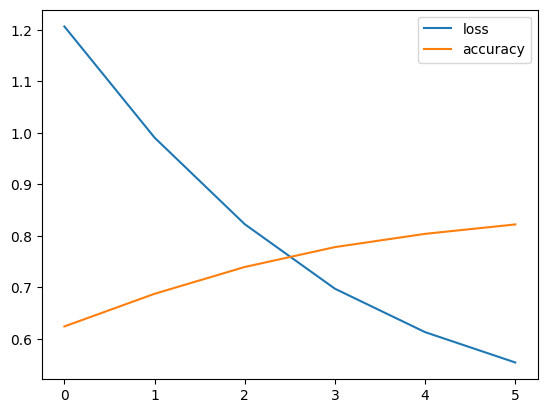

In [12]:
test_loss = trainer.metrics_history["test_loss"]
plt.plot(np.arange(0, len(test_loss), 1), test_loss, label="loss")
test_accuracy = trainer.metrics_history["test_accuracy"]
plt.plot(np.arange(0, len(test_accuracy), 1), test_accuracy, label="accuracy")
plt.legend()

#### Using the trained model

In this section we are going to explore how we can use the trained model. We will first start by defining some constants used in our predictions. The most important variables are **text**, which is our input, and **temperature**, which affects the randomness of the output.

In [35]:
state = trainer.train_state

model = GPT(**model_config)

text = "What is the meaning of life the universe and everything? It is "
# Ensure that the input is the correct length:
text = text.rjust(model_config["block_size"])
text = text[:model_config["block_size"]]

temperature=0.4
max_generated_tokens=128

tokenized_input = np.array([[dataset.stoi[t] for t in text]])


Let's see explore which characters the model thinks are likely after this text input, and how different temperatures affect the probablities.

Text(0.5, 1.0, 'temperature = 2.0')

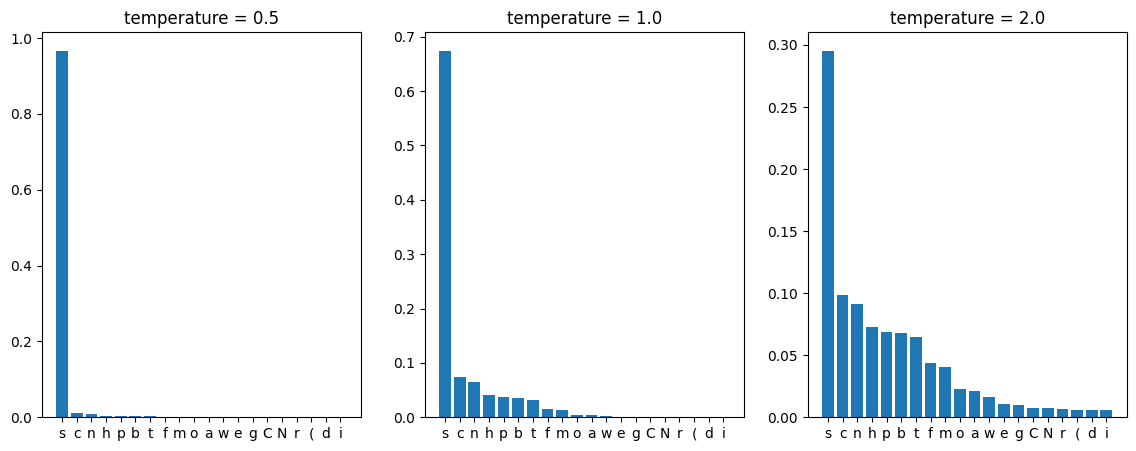

In [36]:
import flax.linen as nn
# Predict the next token. We are only interested in the last token in the sequence

predictions = model.apply(state.params, tokenized_input, training=False)[0,-1]

predictions_low_temperature = predictions/0.5
predictions_medium_temperature = predictions
predictions_high_temperature = predictions/2

probabilities_low = nn.softmax(predictions_low_temperature)
probabilities_medium = nn.softmax(predictions_medium_temperature)
probabilities_high = nn.softmax(predictions_high_temperature)



indexes = jnp.argsort(-predictions)

labels = [dataset.itos[int(index)]for index in indexes] 

probabilities_low_sorted =  [float(probabilities_low[int(index)]) for index in indexes]
probabilities_medium_sorted =  [float(probabilities_medium[int(index)]) for index in indexes]
probabilities_high_sorted =  [float(probabilities_high[int(index)]) for index in indexes]

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].bar(labels[:20], probabilities_low_sorted[:20])
axes[1].bar(labels[:20], probabilities_medium_sorted[:20])
axes[2].bar(labels[:20], probabilities_high_sorted[:20])

axes[0].set_title("temperature = 0.5")
axes[1].set_title("temperature = 1.0")
axes[2].set_title("temperature = 2.0")


Now we will make the model predict one full word. Note that the random key is constant, so it will always generates the same word for the same input.

In [37]:
# We want the model to stop generating after it reaches one of these characters
stop_tokens = [dataset.stoi[" "], dataset.stoi["\n"],  dataset.stoi["."],  dataset.stoi[","]]
print("Generated sequence: ")
model.verbose_generate(state.params, tokenized_input, max_generated_tokens, key1, dataset.itos, temperature, stop_tokens=stop_tokens)
print()

Generated sequence: 
 What is the meaning of life the universe and everything? It is something




Finally we will use the trained model to generate longer sequences. Try experimenting with different input texts and temperatures!<br/>Note that the model is trained for a short while on a small dataset, so the performance will not match other large language models you may be familiar with.

In [38]:
state=trainer.train_state
print("Generated sequence: ")
model.verbose_generate(state.params, tokenized_input, max_generated_tokens, key1, dataset.itos, temperature)
print() 

Generated sequence: 
 What is the meaning of life the universe and everything? It is something
that the ear-has, we all willing bearing all the past,
and a try to chup: accont in his shame overconce and the mind i

